## Import CSV

In [1]:
import pandas
def read_csv(filename,folder):
    folder=folder+"/"+filename+".csv"
    return pandas.read_csv(folder,encoding='ISO-8859-1')


In [2]:
folder="/nfs/Workspace/"
data=read_csv(filename="WEN",folder=folder)
data.columns = ( 'DATE','vfx','vix' ,'vbx', 'vmt','rwm','dog','psh','spx')
data = data.fillna(method='ffill')
data.head()

,DATE,vfx,vix,vbx,vmt,rwm,dog,psh,spx
0,2017-09-26,218.231659,10.17,9.976272,25.884623,43.633526,64.915009,31.513302,4843.140137
1,2017-09-27,219.121857,9.87,9.948611,26.088360,42.785797,64.758858,31.406380,4862.930176
2,2017-09-28,219.424911,9.55,9.948611,26.156273,42.688362,64.680794,31.367496,4869.810059
3,2017-09-29,220.248840,9.51,9.959696,26.317326,42.571430,64.602730,31.270290,4887.970215
4,2017-10-02,221.101120,9.45,9.959696,26.447330,42.045261,64.173347,31.114765,4906.919922


In [3]:
from matplotlib import pyplot
def plot_data(dataset,groups):
    i = 1
    pyplot.figure()
    values = dataset.values
    for group in groups:
    	pyplot.subplot(len(groups), 1, i)
    	pyplot.plot(values[:, group])
    	pyplot.title(dataset.columns[group], y=0.5, loc='right')
    	i += 1
    pyplot.show()

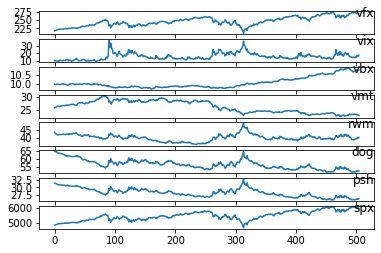

In [5]:
plot_data(data,groups=list(range(1,9)))

## Data Summary

In [ ]:
data.describe()

## Independent and identically distributed (I.I.D.) Testing

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
sm.graphics.tsa.plot_acf(data['vfx'].values, lags=40)
plt.show()

## *** LSTM ***

In [6]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
def Standard_MinMax(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    
    return sc.fit_transform(data.reshape(-1,1))

In [7]:
#folder="/Users/wenyongjing/Downloads/第二章"
#data=read_csv(filename="WEN",folder=folder)
#data.columns = ( 'DATE','vfx','vix' ,'vbx', 'vmt','rwm','dog','psh', 'spx')
del data['DATE']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
data.head()

,vfx,vix,vbx,vmt,rwm,dog,psh,spx
0,218.231659,10.17,9.976272,25.884623,43.633526,64.915009,31.513302,4843.140137
1,219.121857,9.87,9.948611,26.088360,42.785797,64.758858,31.406380,4862.930176
2,219.424911,9.55,9.948611,26.156273,42.688362,64.680794,31.367496,4869.810059
3,220.248840,9.51,9.959696,26.317326,42.571430,64.602730,31.270290,4887.970215
4,221.101120,9.45,9.959696,26.447330,42.045261,64.173347,31.114765,4906.919922


## Series to Supervised

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.128095,0.036551,0.234604,0.420893,0.585652,1.000000,0.804889,0.120808,0.142167,0.025905,0.212442,0.446599,0.519951,0.988290,0.790167,0.134832
2,0.142167,0.025905,0.212442,0.446599,0.519951,0.988290,0.790167,0.134832,0.146958,0.014549,0.212442,0.455168,0.512399,0.982436,0.784814,0.139708
3,0.146958,0.014549,0.212442,0.455168,0.512399,0.982436,0.784814,0.139708,0.159983,0.013130,0.221323,0.475488,0.503337,0.976582,0.771430,0.152577
4,0.159983,0.013130,0.221323,0.475488,0.503337,0.976582,0.771430,0.152577,0.173455,0.011001,0.221323,0.491891,0.462557,0.944382,0.750016,0.166005
5,0.173455,0.011001,0.221323,0.491891,0.462557,0.944382,0.750016,0.166005,0.181091,0.013130,0.228727,0.498012,0.458026,0.929746,0.743325,0.173666


In [10]:
pred = {'vfx': 8}
reframed = pandas.concat([reframed.iloc[:,0:8],reframed.iloc[:,pred['vfx']]],axis=1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.128095,0.036551,0.234604,0.420893,0.585652,1.000000,0.804889,0.120808,0.142167
2,0.142167,0.025905,0.212442,0.446599,0.519951,0.988290,0.790167,0.134832,0.146958
3,0.146958,0.014549,0.212442,0.455168,0.512399,0.982436,0.784814,0.139708,0.159983
4,0.159983,0.013130,0.221323,0.475488,0.503337,0.976582,0.771430,0.152577,0.173455
5,0.173455,0.011001,0.221323,0.491891,0.462557,0.944382,0.750016,0.166005,0.181091


In [11]:
reframed.shape

(504, 9)

## Data Split

In [12]:
train = reframed.values[:400,:]
test = reframed.values[400:504,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((400, 8), (400,), (104, 8), (104,))

## LSTM

In [13]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

import keras
from keras import layers
from keras.layers import Dropout

model = keras.models.Sequential()
model.add(layers.LSTM(6, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 360       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 367
Trainable params: 367
Non-trainable params: 0
_________________________________________________________________


## Training

In [14]:
history = model.fit(train_X, train_y, epochs=80, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/80
6/6 [==============================] - 0s 64ms/step - loss: 0.3884 - val_loss: 0.6219
Epoch 2/80
6/6 [==============================] - 0s 4ms/step - loss: 0.3634 - val_loss: 0.5985
Epoch 3/80
6/6 [==============================] - 0s 12ms/step - loss: 0.3406 - val_loss: 0.5762
Epoch 4/80
6/6 [==============================] - 0s 4ms/step - loss: 0.3193 - val_loss: 0.5551
Epoch 5/80
6/6 [==============================] - 0s 12ms/step - loss: 0.2995 - val_loss: 0.5348
Epoch 6/80
6/6 [==============================] - 0s 4ms/step - loss: 0.2810 - val_loss: 0.5155
Epoch 7/80
6/6 [==============================] - 0s 11ms/step - loss: 0.2638 - val_loss: 0.4967
Epoch 8/80
6/6 [==============================] - 0s 4ms/step - loss: 0.2476 - val_loss: 0.4785
Epoch 9/80
6/6 [==============================] - 0s 4ms/step - loss: 0.2323 - val_loss: 0.4608
Epoch 10/80
6/6 [==============================] - 0s 3ms/step - loss: 0.2179 - val_loss: 0.4433
Epoch 11/80
6/6 [==================

## Plot Loss Curve

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


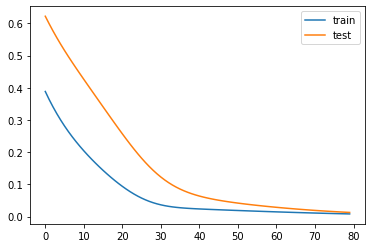

In [15]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [31]:
# folder="/nfs/Workspace/"
pred_data=read_csv(filename="PRED",folder=folder)
pred_data.columns = ( 'Date','vfx','vix' ,'vbx', 'vmt','rwm','dog','psh', 'spx')
#pred_data.isnull().sum()
pred_data = pred_data.fillna(method='ffill')
pred_data.head()


,Date,vfx,vix,vbx,vmt,rwm,dog,psh,spx
0,2019-09-27,268.591461,5978.109863,23.038769,40.458401,52.470287,26.140480,141.059998,93.279999
1,2019-09-30,269.957397,6008.589844,23.182716,40.438496,52.261082,26.011070,138.869995,90.720001
2,2019-10-01,266.665375,5935.200195,23.015104,41.204865,52.948467,26.339569,139.630005,89.519997
3,2019-10-02,261.889435,5828.930176,22.696642,41.543262,53.954639,26.807430,141.259995,87.839996
4,2019-10-03,264.041565,5876.859863,22.826788,41.384018,53.665741,26.598385,141.899994,87.440002


In [32]:
del pred_data['Date']
scaler = MinMaxScaler(feature_range=(0, 1))
pred_scaled = scaler.fit_transform(pred_data)
pred_data.head()

,vfx,vix,vbx,vmt,rwm,dog,psh,spx
0,268.591461,5978.109863,23.038769,40.458401,52.470287,26.140480,141.059998,93.279999
1,269.957397,6008.589844,23.182716,40.438496,52.261082,26.011070,138.869995,90.720001
2,266.665375,5935.200195,23.015104,41.204865,52.948467,26.339569,139.630005,89.519997
3,261.889435,5828.930176,22.696642,41.543262,53.954639,26.807430,141.259995,87.839996
4,264.041565,5876.859863,22.826788,41.384018,53.665741,26.598385,141.899994,87.440002


In [33]:
pred_reframed = series_to_supervised(pred_scaled, 1, 1)
pred_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.509917,0.506829,0.545241,0.334866,0.369087,0.520731,0.071203,0.862443,0.520807,0.517719,0.570215,0.334036,0.361712,0.511007,0.032700,0.833484
2,0.520807,0.517719,0.570215,0.334036,0.361712,0.511007,0.032700,0.833484,0.494561,0.491499,0.541135,0.366002,0.385943,0.535689,0.046062,0.819909
3,0.494561,0.491499,0.541135,0.366002,0.385943,0.535689,0.046062,0.819909,0.456484,0.453531,0.485885,0.380116,0.421411,0.570843,0.074719,0.800905
4,0.456484,0.453531,0.485885,0.380116,0.421411,0.570843,0.074719,0.800905,0.473642,0.470655,0.508464,0.373474,0.411227,0.555136,0.085970,0.796380
5,0.473642,0.470655,0.508464,0.373474,0.411227,0.555136,0.085970,0.796380,0.503571,0.500513,0.549175,0.358114,0.385241,0.527462,0.085970,0.806335


In [34]:
pred = {'vfx': 8}
pred_reframed = pandas.concat([pred_reframed.iloc[:,0:8],pred_reframed.iloc[:,pred['vfx']]],axis=1)
pred_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.509917,0.506829,0.545241,0.334866,0.369087,0.520731,0.071203,0.862443,0.520807
2,0.520807,0.517719,0.570215,0.334036,0.361712,0.511007,0.032700,0.833484,0.494561
3,0.494561,0.491499,0.541135,0.366002,0.385943,0.535689,0.046062,0.819909,0.456484
4,0.456484,0.453531,0.485885,0.380116,0.421411,0.570843,0.074719,0.800905,0.473642
5,0.473642,0.470655,0.508464,0.373474,0.411227,0.555136,0.085970,0.796380,0.503571


In [35]:
pred_test = pred_reframed.values[:,:]
pred_test_X , pred_test_y  = pred_test[:, :-1], pred_test[:, -1]
pred_test_X.shape, pred_test_y.shape

((254, 8), (254,))

In [36]:
pred_test_X  = pred_test_X.reshape((pred_test_X.shape[0], 1, pred_test_X.shape[1]))
pred_test_X.shape, pred_test_y.shape

pred_yhat = model.predict(pred_test_X)
pred_test_X = pred_test_X.reshape((pred_test_X.shape[0], pred_test_X.shape[2]))
pred_yhat.shape, pred_test_X.shape

((254, 1), (254, 8))

## Invert scaling for forecast

In [37]:
pred = {'VFINX': 0}
pred_inv_yhat = concatenate((pred_yhat, numpy.delete(pred_test_X, pred['VFINX'], axis=1)), axis=1)
pred_inv_yhat = scaler.inverse_transform(pred_inv_yhat)
pred_inv_yhat = pred_inv_yhat[:,0]
pred_inv_yhat.shape,pred_inv_yhat

((254,),
 array([289.10214938, 289.2306431 , 287.11508342, 283.97362247,
        285.18452269, 287.5830048 , 286.98668689, 284.20777755,
        285.81227061, 286.98060125, 289.57077353, 288.8626862 ,
        290.12198743, 289.8236341 , 290.60121285, 290.00161288,
        290.89187316, 290.82158926, 291.69390662, 292.44345705,
        293.27244226, 293.77709429, 293.59882393, 293.85396474,
        292.982709  , 295.10706819, 295.82585399, 295.80729055,
        295.53266672, 295.88407876, 296.3203907 , 295.97671655,
        296.13790376, 296.34567526, 296.35540182, 297.58623363,
        297.414019  , 296.86649087, 296.94586585, 297.12847242,
        297.16083696, 298.30594647, 298.84579653, 299.21186195,
        297.74314444, 296.60383647, 296.18457777, 297.77544917,
        297.99838992, 299.19761976, 298.82896757, 298.85159807,
        299.18534381, 300.15017187, 300.5673447 , 301.63545667,
        301.80311828, 301.87426195, 302.37276105, 302.67701312,
        302.99631482, 303.32163

## Invert scaling for actual

In [38]:
real = pred_test_y.reshape((len(pred_test_y), 1))
inv_y = concatenate((real, numpy.delete(pred_test_X, pred['VFINX'], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y

array([269.95739746, 266.66537476, 261.88943481, 264.04156494,
       267.79547119, 266.59655762, 262.44955444, 264.9161377 ,
       266.62606812, 269.56430054, 269.19088745, 271.87365723,
       271.34295654, 272.10946655, 271.04821777, 272.91531372,
       271.95227051, 272.73846436, 273.25927734, 274.37954712,
       275.90274048, 275.81433105, 276.60043335, 275.7749939 ,
       278.46755981, 279.49942017, 279.1652832 , 279.38146973,
       280.27572632, 281.04223633, 280.48214722, 280.93414307,
       281.15036011, 281.45498657, 283.66604614, 283.81344604,
       283.65625   , 282.64407349, 282.22149658, 282.84057617,
       284.9927063 , 285.62161255, 286.85003662, 285.75924683,
       283.30245972, 281.42550659, 283.2336731 , 283.73486328,
       286.33901978, 285.45458984, 285.15975952, 285.98519897,
       288.48129272, 288.55004883, 290.61373901, 290.7119751 ,
       290.61373901, 291.92071533, 293.38677979, 293.63360596,
       293.60397339, 295.13421631, 295.14404297, 293.47

## RMSE

In [41]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, pred_inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.620


In [42]:
from RegscorePy import *
aic.aic(inv_y, pred_inv_yhat, 367)

2096.655265301204

In [43]:
#inv_y = np.cumprod(inv_y+1)
#inv_yhat = np.cumprod(inv_yhat+1)
inv_y,pred_inv_yhat

(array([269.95739746, 266.66537476, 261.88943481, 264.04156494,
        267.79547119, 266.59655762, 262.44955444, 264.9161377 ,
        266.62606812, 269.56430054, 269.19088745, 271.87365723,
        271.34295654, 272.10946655, 271.04821777, 272.91531372,
        271.95227051, 272.73846436, 273.25927734, 274.37954712,
        275.90274048, 275.81433105, 276.60043335, 275.7749939 ,
        278.46755981, 279.49942017, 279.1652832 , 279.38146973,
        280.27572632, 281.04223633, 280.48214722, 280.93414307,
        281.15036011, 281.45498657, 283.66604614, 283.81344604,
        283.65625   , 282.64407349, 282.22149658, 282.84057617,
        284.9927063 , 285.62161255, 286.85003662, 285.75924683,
        283.30245972, 281.42550659, 283.2336731 , 283.73486328,
        286.33901978, 285.45458984, 285.15975952, 285.98519897,
        288.48129272, 288.55004883, 290.61373901, 290.7119751 ,
        290.61373901, 291.92071533, 293.38677979, 293.63360596,
        293.60397339, 295.13421631, 295.

## Predict vs Real

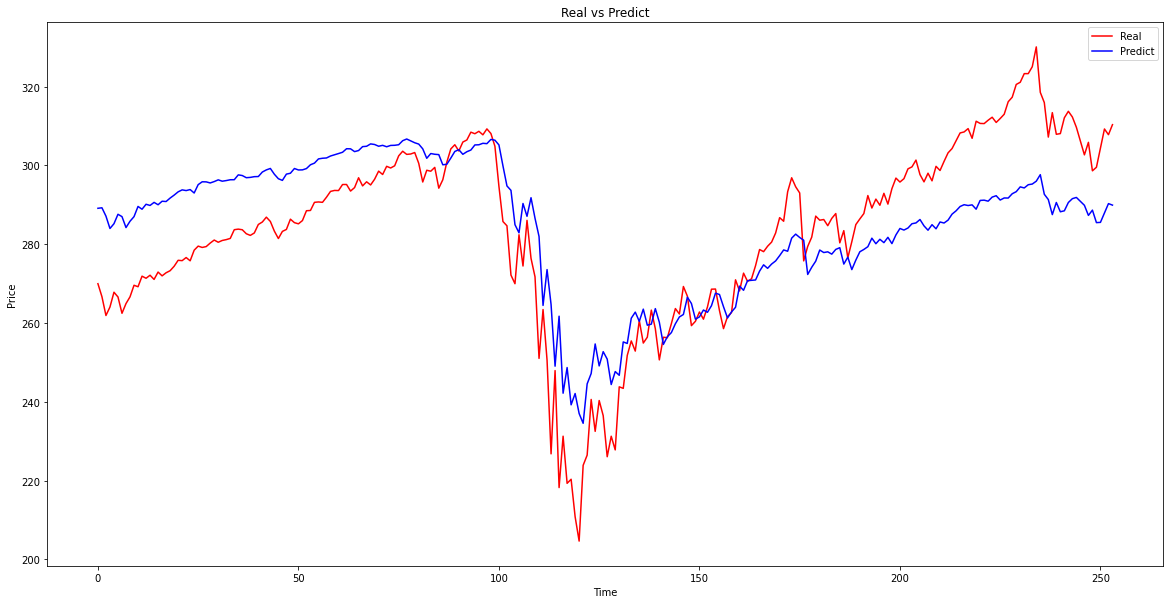

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(pred_inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [45]:
result_pred = pandas.DataFrame(pred_inv_yhat,columns =['Pred_VFNIX'])
temp =read_csv(filename="PRED",folder=folder)
temp.columns = ( 'Date','vfx','vix' ,'vbx', 'vmt','rwm','dog','psh', 'spx')                                                    
temp = temp[['Date','vfx']]
result = pandas.concat([temp,result_pred], axis = 1)
result.to_csv('final.csv')